<a href="https://colab.research.google.com/github/jan-felix/SLOG/blob/master/Ex_Ante_vs_Ex_Post_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [415]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import datetime
import pandas_datareader as pdr
import os
start = datetime.datetime(2011, 1, 1)
end = datetime.datetime.today()
index = pd.date_range(start, end, freq="D")
os.environ["ALPHAVANTAGE_API_KEY"] = "H6AXUXK0Z2CBTV59" 

In [416]:
GOVT = pdr.av.time_series.AVTimeSeriesReader(symbols = "GOVT",start = start, end = end).read()
IVV = pdr.av.time_series.AVTimeSeriesReader(symbols = "IVV",start = start, end = end).read()

In [489]:
sampling = "W"
hist_year_window = 1
fut_year_window = 1

if sampling == "W":
  hist_window = hist_year_window * 52
  fut_window = fut_year_window * 52
  pa_value = 52
if sampling == "BM":
  hist_window = hist_year_window * 12
  fut_window = fut_year_window * 12
  pa_value = 12

df =pd.merge(GOVT["close"],IVV["close"], left_index =True, right_index = True)
df.index = pd.DatetimeIndex(df.index)
df = df.resample(sampling).last()

df.columns = ["GOVT","IVV"]
df = df*100/df.iloc[0,:]

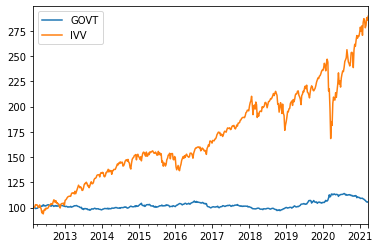

In [490]:
df.plot()

In [482]:
df.tail()

,GOVT,IVV
2021-02-28,107.171636,277.913664
2021-03-07,106.204674,280.315935
2021-03-14,105.600322,287.988644
2021-03-21,105.338437,285.506297
2021-03-28,105.761483,289.328092


In [491]:
df_ret = df.pct_change().dropna()

In [492]:
cov_govt_ivv = df_ret["IVV"].cov(df_ret["GOVT"])
var_govt = df_ret["GOVT"].var()
var_ivv = df_ret["IVV"].var()

In [493]:
df_ret.describe()

,GOVT,IVV
count,474.000000,474.000000
mean,0.000134,0.002484
std,0.005571,0.021772
min,-0.021705,-0.148739
25%,-0.002849,-0.007342
50%,0.000394,0.003804
75%,0.003599,0.013735
max,0.027941,0.120874


In [494]:
w1 = 0.40
w2 = 1-w1
mark_var = (np.square(w1)*var_govt + np.square(w2)*var_ivv + 2*w1*w2*cov_govt_ivv)*pa_value
mark_std = np.sqrt(mark_var)
mark_std

0.09094714584428301

In [495]:
risk_target = 0.075
#For each period (week, month) calculate the historic (co-)variances and iterate over 100 000 portfolios to find portfolio that is at 7.5% risk.
#Make DF with bond weight, portfolio standard deviation and (co-)variances 
lol = list()
for n in range(hist_window, len(df_ret.index)):
  df_a = df_ret.iloc[:n,].tail(hist_window)
  cov_govt_ivv_a = df_a["IVV"].cov(df_a["GOVT"])
  var_govt_a = df_a["GOVT"].var()
  var_ivv_a = df_a["IVV"].var()
  for i in range(0,100001):
    w1 = i/100000
    w2 = 1-w1
    mark_var = (np.square(w1)*var_govt_a + np.square(w2)*var_ivv_a + 2*w1*w2*cov_govt_ivv_a)*pa_value
    mark_std = np.sqrt(mark_var)
    if risk_target == round(mark_std,4):
      lol.append([df_ret.index[n],w1,mark_std,var_govt_a,var_ivv_a,cov_govt_ivv_a])
      break
    if i == 100000:
      w1 = 0
      mark_std = np.sqrt((var_ivv_a*pa_value))
      lol.append([df_ret.index[n],w1,mark_std,var_govt_a,var_ivv_a,cov_govt_ivv_a])

#Construct dataframe
ex_a_df = pd.DataFrame(lol, columns = ["Date","GOVT_W","ex_a_std","real_VarGOVT","real_VarIVV","real_COV"])
ex_a_df.index = pd.DatetimeIndex(ex_a_df["Date"])
ex_a_df = ex_a_df[["GOVT_W","ex_a_std","real_VarGOVT","real_VarIVV","real_COV"]]

#construct new dataframe 
#1 compute the standard deviation that a portfolio would have had in the next (e.g.) 12 months, that would have achieved the risk target in the previous (e.g) 12 months
#2 compute the (co-)variances that actually happened in the next (e.g.) 12 months (forw_) in the same row as the (co-)variances that happened in the previous time periods (e.g. 12 months)
#3 compute the returns of a portfolio that rebalances in each period based on the weights of the target volatility portfolio
#1 and 3 are different because in 1 we assume weights to be constant for the next 12 months, whereas in 3 we rebalance in each period
#shift 3 back so that it is aligned with 1
df_risk = ex_a_df.copy(deep=True)
for month in ex_a_df.index[:(len(ex_a_df.index)-fut_window)]:
  df_period = df_ret[month:].head(fut_window)
  period_port_ret = (ex_a_df["GOVT_W"][month]*df_period["GOVT"]+(1-ex_a_df["GOVT_W"][month])*df_period["IVV"]) #actual future portfolio returns
  df_risk.loc[month,"ex_p_std"] = period_port_ret.std()*np.sqrt(pa_value) #standard deviation of actual future portfolio returns
  df_risk.loc[month,"forw_COV"] = df_period["IVV"].cov(df_period["GOVT"]) #forward covariance
  df_risk.loc[month,"forw_VarGOVT"] = df_period["GOVT"].var()#forward var
  df_risk.loc[month,"forw_VarIVV"] = df_period["IVV"].var()#forward var



In [503]:
df_risk["IVV_W"] = 1-ex_a_df["GOVT_W"]
df_risk["target_risk_real_ret"] = ex_a_df["GOVT_W"]*df_ret["GOVT"]+df_risk["IVV_W"]*df_ret["IVV"]
df_risk["target_risk_realized_std"] = (df_risk["target_risk_real_ret"].rolling(fut_window).std()*np.sqrt(pa_value)).shift(-fut_window)

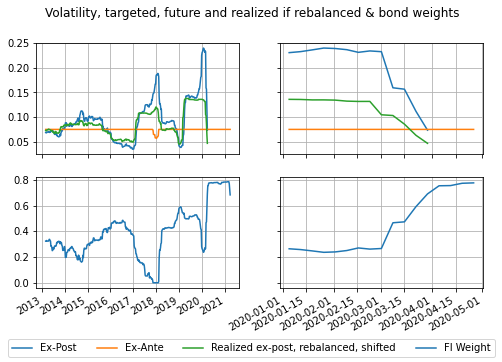

In [533]:
fig, axs = plt.subplots(2,2,figsize =(8,5),sharex="col", sharey="row")
axs[0,0].plot(df_risk[["ex_p_std","ex_a_std","target_risk_realized_std"]])
axs[0,0].grid()

l1,l2,l3, = axs[0,1].plot(df_risk[["ex_p_std","ex_a_std","target_risk_realized_std"]]["2020-01-01":"2020-05-01"])
axs[0,1].grid()

axs[1,0].plot(df_risk["GOVT_W"])
axs[1,0].grid()

l4, = axs[1,1].plot(df_risk["GOVT_W"]["2020-01-01":"2020-05-01"])
#axs[1,1].legend(labels=["Bond Weights"])
axs[1,1].grid()

fig.legend((l1, l2, l3, l4), ("Ex-Post","Ex-Ante","Realized ex-post, rebalanced, shifted","FI Weight"), 'lower center', ncol = 4)
fig.suptitle("Volatility, targeted, future and realized if rebalanced & bond weights")
fig.autofmt_xdate()

Text(0.5, 1.0, 'Variances IVV')

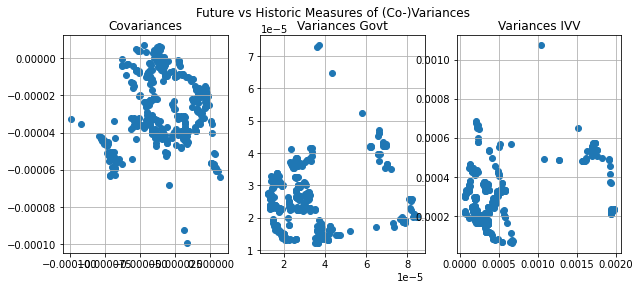

In [566]:
fig, axs = plt.subplots(1,3, figsize=(10,4))
fig.suptitle("Future vs Historic Measures of (Co-)Variances")
axs[0].scatter(x = df_risk["forw_COV"], y = df_risk["real_COV"], marker='o')
axs[0].grid()
axs[0].set_title("Covariances")

axs[1].scatter(x = df_risk["forw_VarGOVT"], y = df_risk["real_VarGOVT"])
axs[1].grid()
axs[1].set_title("Variances Govt")

axs[2].scatter(x = df_risk["forw_VarIVV"], y = df_risk["real_VarIVV"])
axs[2].grid()
axs[2].set_title("Variances IVV")